# S&P 500 Analysis and Prediction 

#### Importing All of The Tools That i'll Need

In [42]:
import pandas as pd 
import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt

### Downloading and Exploring My Data 

In [3]:
#I'm using pandas to download my data into the notebook
stock_df = pd.read_csv('^GSPC1980_2020.csv',date_parser = True )

In [4]:
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-01-02,107.940002,108.430000,105.290001,105.760002,105.760002,40610000
1,1980-01-03,105.760002,106.080002,103.260002,105.220001,105.220001,50480000
2,1980-01-04,105.220001,107.080002,105.089996,106.519997,106.519997,39130000
3,1980-01-07,106.519997,107.800003,105.800003,106.809998,106.809998,44500000
4,1980-01-08,106.809998,109.290001,106.290001,108.949997,108.949997,53390000


In [5]:
stock_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
10082,2019-12-24,3225.449951,3226.429932,3220.510010,3223.379883,3223.379883,1296540000
10083,2019-12-26,3227.199951,3240.080078,3227.199951,3239.909912,3239.909912,2160680000
10084,2019-12-27,3247.229980,3247.929932,3234.370117,3240.020020,3240.020020,2428670000
10085,2019-12-30,3240.090088,3240.919922,3216.570068,3221.290039,3221.290039,3013290000
10086,2019-12-31,3215.179932,3231.719971,3212.030029,3230.780029,3230.780029,2893810000


In [6]:
stock_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10087.000000,10087.000000,10087.000000,10087.000000,10087.000000,1.008700e+04
mean,998.830845,1004.571136,992.714297,999.058833,999.058833,1.666173e+09
std,744.498951,747.729578,740.940145,744.572446,744.572446,1.768667e+09
min,98.220001,99.580002,94.230003,98.220001,98.220001,1.499000e+07
25%,330.369995,332.279999,328.419998,330.369995,330.369995,1.723000e+08
50%,987.760010,996.679993,977.489990,987.760010,987.760010,8.803000e+08
75%,1369.025024,1379.570007,1360.559998,1369.205017,1369.205017,3.215970e+09
max,3247.229980,3247.929932,3234.370117,3240.020020,3240.020020,1.145623e+10


In [7]:
type(stock_df['Date'][2])

str

In [8]:
#Set the format of the date in the date column to datetime 
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
#Put the date column as your index to avoid having to drop the column later on
stock_df = stock_df.set_index(['Date'])


In [9]:
#I resampled my data to Average price by month for a more meaningful grap
d = stock_df.resample('M').mean()
roll_mean = d['Open'].rolling(3).mean()
roll_std = d['Open'].rolling(3).std()

In [10]:
d.shape[0]

480

/Users/andrewghan/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


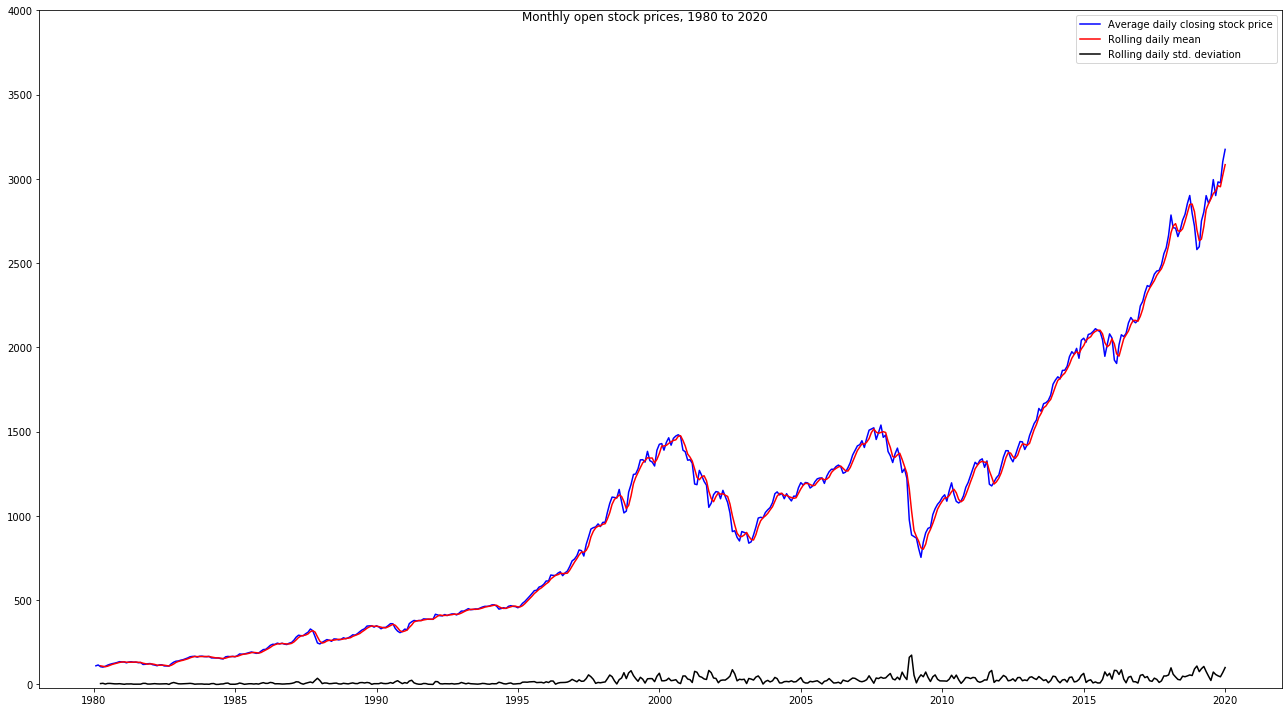

In [11]:



fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(d['Open'], color='blue',label='Average daily closing stock price')
ax.plot(roll_mean, color='red', label='Rolling daily mean')
ax.plot(roll_std, color='black', label='Rolling daily std. deviation')

ax.set_ylim(-20, 4000)
ax.legend()
fig.suptitle('Monthly open stock prices, 1980 to 2020')
fig.tight_layout()

In [12]:
New = d['2019-12']['Open'].reset_index(drop=True)
Old = d['1980-01']['Open'].reset_index(drop=True)

In [13]:
(New - Old)/Old

0    27.71321
Name: Open, dtype: float64

Looking at my data we can see that the S&P 500 has increased by 27% in the last 40 years. I want to point out two peaks and drops of the S&P 500. The First Being from 2000-2003 and the second from 2008-2010. Both time periods display our economy peaking and then going into a recession period followed by a period of economic growth. After the United States' last recession in 2008, we have seen 10 years of fairly constant growth. Due to volitility of the S&P 500 from extrogenous factors during recession periods, im going to train and test my model on a period of low volitility. 


In [14]:
#I am resampling my original data to be in days 
df = stock_df.resample('D').mean()
#because there are days missing im filling values with the value from the previous day 
df.fillna(method='ffill',inplace=True)


In [17]:
#I chose to train my model on these 3 years where extrogenous factors don't create alot of volitility in the index
training = df['2016-01-04':'2018-12-31'].copy()
training.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,2038.199951,2038.199951,1989.680054,2012.660034,2012.660034,4.304880e+09
2016-01-05,2013.780029,2021.939941,2004.170044,2016.709961,2016.709961,3.706620e+09
2016-01-06,2011.709961,2011.709961,1979.050049,1990.260010,1990.260010,4.336660e+09
2016-01-07,1985.319946,1985.319946,1938.829956,1943.089966,1943.089966,5.076590e+09
2016-01-08,1945.969971,1960.400024,1918.459961,1922.030029,1922.030029,4.664940e+09


In [18]:
#I chose to test my model's performance on 2019 
testing = df['2019-01-01':].copy()
testing.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-01,2498.939941,2509.239990,2482.820068,2506.850098,2506.850098,3.442870e+09
2019-01-02,2476.959961,2519.489990,2467.469971,2510.030029,2510.030029,3.733160e+09
2019-01-03,2491.919922,2493.139893,2443.959961,2447.889893,2447.889893,3.822860e+09
2019-01-04,2474.330078,2538.070068,2474.330078,2531.939941,2531.939941,4.213410e+09
2019-01-05,2474.330078,2538.070068,2474.330078,2531.939941,2531.939941,4.213410e+09


In [19]:
#dropping Adj Close 
train = training.drop(['Adj Close'],axis = 1)

In [22]:
#scaling my data allows me to pass it through my model 
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
train

array([[0.18561479, 0.17478583, 0.16076853, 0.16663799, 0.47211877],
       [0.16348246, 0.15992171, 0.17374065, 0.17031416, 0.37653833],
       [0.16160631, 0.15056995, 0.15125205, 0.1463052 , 0.47719608],
       ...,
       [0.60303981, 0.61547118, 0.5933607 , 0.59605872, 0.37589927],
       [0.60303981, 0.61547118, 0.5933607 , 0.59605872, 0.37589927],
       [0.60319381, 0.60538805, 0.60225066, 0.61522063, 0.33440056]])

In [23]:
#I'm creating two empty lists that im going to create my training variables with 
X_train = []
y_train = []

In [25]:
#Then we are creating a for loop that iteraterates through our df and grabbes sets of 60 days of values. 
#we are then going to use these sets to predict 1 day ahead.
for i in range(60,train.shape[0]):
    X_train.append(train[i-60:i])
    y_train.append(train[i,0])

In [26]:
# we are turning our X & Y trains into arrays for the model take it 
X_train,y_train = np.array(X_train), np.array(y_train)

In [27]:
#Here I am checking to see whether my X & Y variables are structured properly 
X_train.shape, y_train.shape

((1033, 60, 5), (1033,))


Preping Test Data 

In [28]:
#Because this model uses the past 60 days to predict 1 day into the future we need to add the 60 days previous from 2018 to get the first day of 2019. 
#we are taking the last 60 days of our training data and making a new datafrane
past_60_days = training.tail(60)


In [29]:
#Here we are adding testing data to the df we just created and dropping the Adj Close column
dff = past_60_days.append(testing)
dff = dff.drop(['Adj Close'],axis = 1)
dff.head()

,Open,High,Low,Close,Volume
Date,,,,,
2018-11-02,2745.449951,2756.550049,2700.439941,2723.060059,4.237930e+09
2018-11-03,2745.449951,2756.550049,2700.439941,2723.060059,4.237930e+09
2018-11-04,2745.449951,2756.550049,2700.439941,2723.060059,4.237930e+09
2018-11-05,2726.370117,2744.270020,2717.939941,2738.310059,3.623320e+09
2018-11-06,2738.399902,2756.820068,2737.080078,2755.449951,3.510860e+09


In [30]:
#now we are scaling the dataframe list we just created and turning it into an array 
inputs =scaler.transform(dff)
inputs

array([[0.82661139, 0.83146705, 0.79707421, 0.81147718, 0.46142257],
       [0.82661139, 0.83146705, 0.79707421, 0.81147718, 0.46142257],
       [0.82661139, 0.83146705, 0.79707421, 0.81147718, 0.46142257],
       ...,
       [1.28138592, 1.28066298, 1.27507361, 1.28072836, 0.17236785],
       [1.27491488, 1.27425477, 1.25913817, 1.26372691, 0.26576911],
       [1.25233824, 1.26584461, 1.25507371, 1.2723411 , 0.2466805 ]])

In [31]:
#now we are repeating what we did earlier 
#first we create two lists X and Y 
#then we are creating a for loop that iteraterates through our df and grabbes sets of 60 days of values. 
#we are then going to use these sets to predict 1 day ahead.
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i,0])

In [32]:
# we are turning our X & Y tests into arrays for the model
X_test, y_test = np.array(X_test), np.array(y_test)


### Building RNN LSTM Model 

Base Model

In [33]:
#This is my base model
#First we initialize our model 
model1 = Sequential()
#Then add our lstm layer because this is a base model I randomly inputed 60 units
model1.add(LSTM(units = 60, activation='relu', input_shape=(X_train.shape[1],5)))
#now we add out dense layer 
model1.add(Dense(1))

In [34]:
#To check if we set up our model to our specifications we can use .summary()
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60)                15840     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 61        
Total params: 15,901
Trainable params: 15,901
Non-trainable params: 0
_________________________________________________________________


In [35]:
#Here I compiled my model using adam optimization and mean_squared_error for loss 
model1.compile(optimizer='adam', loss = 'mean_squared_error')


In [36]:
#Now I am fitting my model using my X and Y train, 10 epochs and a batch size of 200.
model1.fit(X_train,y_train,epochs=10,batch_size=200)


Epoch 1/10
1033/1033 [==============================] - 1s 517us/step - loss: 0.2575
Epoch 2/10
1033/1033 [==============================] - 0s 244us/step - loss: 0.0786
Epoch 3/10
1033/1033 [==============================] - 0s 244us/step - loss: 0.0126
Epoch 4/10
1033/1033 [==============================] - 0s 252us/step - loss: 0.0129
Epoch 5/10
1033/1033 [==============================] - 0s 244us/step - loss: 0.0029
Epoch 6/10
1033/1033 [==============================] - 0s 246us/step - loss: 0.0050
Epoch 7/10
1033/1033 [==============================] - 0s 248us/step - loss: 0.0020
Epoch 8/10
1033/1033 [==============================] - 0s 259us/step - loss: 0.0011
Epoch 9/10
1033/1033 [==============================] - 0s 265us/step - loss: 8.4729e-04
Epoch 10/10
1033/1033 [==============================] - 0s 262us/step - loss: 7.0424e-04


In [37]:
#once we have fit our model we can now use it pass through our X_test and predict our y_test.
y_pred1 = model1.predict(X_test)

In [38]:
#checking to see the output of the model. We need to now scale our data back to values we can interpret.
y_pred1

array([[0.5630385 ],
       [0.56888396],
       [0.5732268 ],
       [0.5715096 ],
       [0.57759833],
       [0.58301455],
       [0.5875458 ],
       [0.59778076],
       [0.6105551 ],
       [0.6237589 ],
       [0.6345689 ],
       [0.6446194 ],
       [0.65298986],
       [0.6598541 ],
       [0.6640846 ],
       [0.670427  ],
       [0.67947394],
       [0.6878944 ],
       [0.70226514],
       [0.7141979 ],
       [0.72405   ],
       [0.7320347 ],
       [0.7339578 ],
       [0.7335821 ],
       [0.73434526],
       [0.7396968 ],
       [0.7439041 ],
       [0.7473565 ],
       [0.7454991 ],
       [0.7438887 ],
       [0.74811965],
       [0.7582208 ],
       [0.76597756],
       [0.77329373],
       [0.77932906],
       [0.78535265],
       [0.79457694],
       [0.8017697 ],
       [0.8039777 ],
       [0.80278146],
       [0.80195886],
       [0.8010536 ],
       [0.8020068 ],
       [0.80833167],
       [0.8167358 ],
       [0.8224549 ],
       [0.8315206 ],
       [0.839

In [77]:
#using .scale_ on our scaler, we can take the first value and use it to scale our predictions. 
scaler.scale_

array([9.06322517e-04, 9.14152060e-04, 8.95247028e-04, 9.07712800e-04,
       1.59764060e-10])

In [39]:
# Here I am setting up my scale
scale = 1/9.06322517e-04
scale

1103.3599863656482

In [48]:
# I created this function to stream line our scaling,graphing, and evaluation process
def ScaleGraphEval(y_pred,name):
    #this scales our prediction to normal values 
    y_pred=y_pred*scale
    #now with our normalized predictions we can graph them against the actual values of each day  
    plt.figure(figsize=(18,5))
    plt.plot(y_test, color = 'b', label = 'Actual S&P Value')
    plt.plot(y_pred ,color ='r', label = 'Predicted S&P Value')
    plt.title(name)
    plt.xlabel('Time')
    plt.ylabel('S&P Index Prediction')
    plt.legend()
    plt.show()
    # This line of code calculates the RMSE and displays it at the bottom of the graph.
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print('The RMSE of this Model is',rmse)

In [40]:
#Here we are scaling our y_test data back to normal.
#This is the only time we will run this code 
y_test = y_test*scale


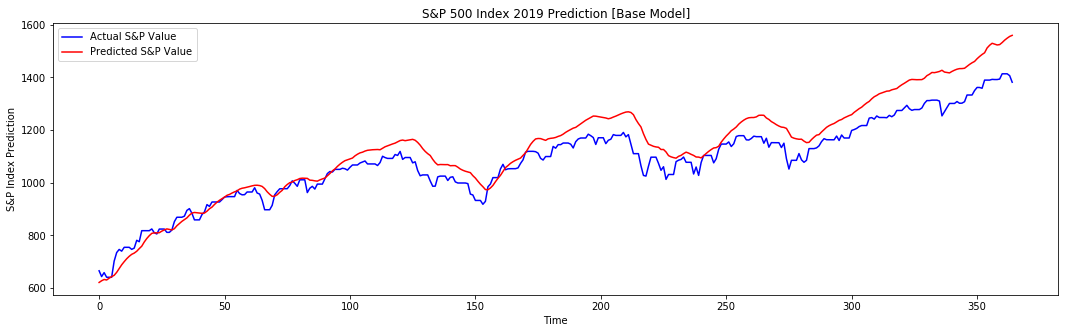

The RMSE of this Model is 69.19742654378514


In [49]:
ScaleGraphEval(y_pred1,'S&P 500 Index 2019 Prediction [Base Model]')


Model 2 

In [50]:
# This is my second model
model2 = Sequential()
# After some trials I found that setting my units to 110 gets me the best rmse score 
model2.add(LSTM(units = 110, activation='relu', input_shape=(X_train.shape[1],5)))

model2.add(Dense(1))



In [51]:
#Here I see that my model is set up properly 
model2.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 110)               51040     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 111       
Total params: 51,151
Trainable params: 51,151
Non-trainable params: 0
_________________________________________________________________


In [52]:

model2.compile(optimizer='adam', loss = 'mean_squared_error')
# After a few trials I found that increaseing my epochs to 80 and reducing my batch size to 50 gave me a lower rmse 
model2.fit(X_train,y_train,epochs=80,batch_size=50)



Epoch 1/80
1033/1033 [==============================] - 1s 931us/step - loss: 0.0901
Epoch 2/80
1033/1033 [==============================] - 1s 660us/step - loss: 0.0033
Epoch 3/80
1033/1033 [==============================] - 1s 659us/step - loss: 0.0011
Epoch 4/80
1033/1033 [==============================] - 1s 660us/step - loss: 7.9845e-04
Epoch 5/80
1033/1033 [==============================] - 1s 662us/step - loss: 6.6989e-04
Epoch 6/80
1033/1033 [==============================] - 1s 670us/step - loss: 6.1627e-04
Epoch 7/80
1033/1033 [==============================] - 1s 681us/step - loss: 5.8185e-04
Epoch 8/80
1033/1033 [==============================] - 1s 669us/step - loss: 5.5287e-04
Epoch 9/80
1033/1033 [==============================] - 1s 665us/step - loss: 5.6062e-04
Epoch 10/80
1033/1033 [==============================] - 1s 678us/step - loss: 5.5648e-04
Epoch 11/80
1033/1033 [==============================] - 1s 662us/step - loss: 5.2578e-04
Epoch 12/80
1033/1033 [========

In [53]:
y_pred2 = model2.predict(X_test)

y_pred2

array([[0.61833894],
       [0.6150499 ],
       [0.6080262 ],
       [0.58944666],
       [0.5953934 ],
       [0.6010817 ],
       [0.60488796],
       [0.6238586 ],
       [0.6459201 ],
       [0.66492474],
       [0.6754515 ],
       [0.68292785],
       [0.685538  ],
       [0.6856714 ],
       [0.680399  ],
       [0.6852293 ],
       [0.69631666],
       [0.7065866 ],
       [0.72917736],
       [0.7420616 ],
       [0.74789   ],
       [0.7495197 ],
       [0.73870194],
       [0.7302488 ],
       [0.7269402 ],
       [0.7366384 ],
       [0.7432433 ],
       [0.7470441 ],
       [0.73791486],
       [0.73287565],
       [0.7429035 ],
       [0.7606387 ],
       [0.77729243],
       [0.7859378 ],
       [0.78922325],
       [0.7945658 ],
       [0.80547076],
       [0.8108178 ],
       [0.799832  ],
       [0.78880703],
       [0.78271735],
       [0.7800103 ],
       [0.7857319 ],
       [0.80113316],
       [0.8193623 ],
       [0.8244976 ],
       [0.8379008 ],
       [0.844

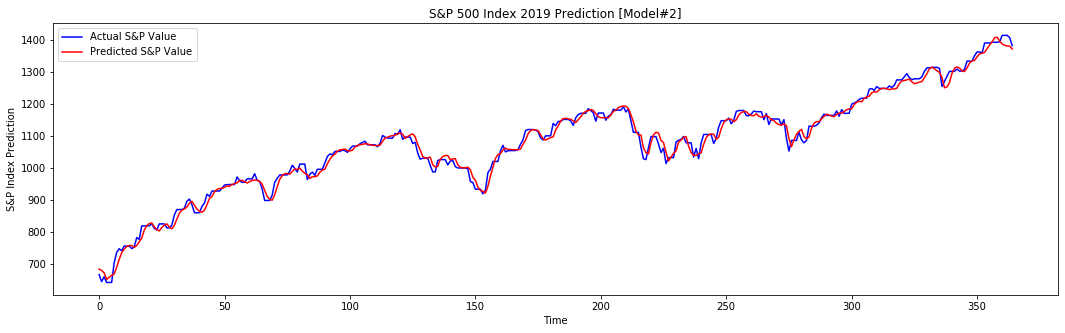

The RMSE of this Model is 15.74761097581176


In [78]:
ScaleGraphEval(y_pred2,'S&P 500 Index 2019 Prediction [Model#2]')
#Here we got an RMSE of 15.75 though I suspect that there is an over fitting problem 


Model 3 

In [58]:
# This is my third model 
model3 = Sequential()
#In this model I am adding a second layer to see how my results vary 
model3.add(LSTM(units = 110, activation='relu',return_sequences = True, input_shape=(X_train.shape[1],5)))
model3.add(Dropout(0.2))
#After some experimination and research I found that lowering the number of units in my second layer increases performance 
model3.add(LSTM(units = 80, activation='relu'))
model3.add(Dropout(0.2))
#I added droupout of .2 to each layer to solve my overfitting problem 
model3.add(Dense(1))



In [59]:
# I see my model is set up exactly to my specifications 
model3.summary()



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 60, 110)           51040     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 110)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 80)                61120     
_________________________________________________________________
dropout_4 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 81        
Total params: 112,241
Trainable params: 112,241
Non-trainable params: 0
_________________________________________________________________


In [60]:
model3.compile(optimizer='adam', loss = 'mean_squared_error')

model3.fit(X_train,y_train,epochs=80,batch_size=50)



Epoch 1/80
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0728
Epoch 2/80
1033/1033 [==============================] - 1s 1ms/step - loss: 0.0086
Epoch 3/80
1033/1033 [==============================] - 1s 1ms/step - loss: 0.0063
Epoch 4/80
1033/1033 [==============================] - 1s 1ms/step - loss: 0.0058
Epoch 5/80
1033/1033 [==============================] - 1s 1ms/step - loss: 0.0051
Epoch 6/80
1033/1033 [==============================] - 1s 1ms/step - loss: 0.0049
Epoch 7/80
1033/1033 [==============================] - 1s 1ms/step - loss: 0.0045
Epoch 8/80
1033/1033 [==============================] - 1s 1ms/step - loss: 0.0046
Epoch 9/80
1033/1033 [==============================] - 1s 1ms/step - loss: 0.0045
Epoch 10/80
1033/1033 [==============================] - 1s 1ms/step - loss: 0.0042
Epoch 11/80
1033/1033 [==============================] - 1s 1ms/step - loss: 0.0040
Epoch 12/80
1033/1033 [==============================] - 1s 1ms/step - loss: 0.0042
E

In [64]:
y_pred3 = model3.predict(X_test)

y_pred3


array([[0.5994863 ],
       [0.6031934 ],
       [0.60343033],
       [0.5975086 ],
       [0.59302044],
       [0.5904738 ],
       [0.5900377 ],
       [0.59639025],
       [0.60743284],
       [0.6213906 ],
       [0.635761  ],
       [0.64957386],
       [0.66078854],
       [0.66898793],
       [0.6728408 ],
       [0.67633086],
       [0.6806083 ],
       [0.6856989 ],
       [0.6946967 ],
       [0.70436054],
       [0.71328926],
       [0.72069925],
       [0.7234374 ],
       [0.72515917],
       [0.72555697],
       [0.727224  ],
       [0.7293298 ],
       [0.73151106],
       [0.7307795 ],
       [0.72971666],
       [0.7311188 ],
       [0.7323966 ],
       [0.74151325],
       [0.7517836 ],
       [0.7610463 ],
       [0.7703382 ],
       [0.7799068 ],
       [0.7882489 ],
       [0.7884612 ],
       [0.7862469 ],
       [0.7828359 ],
       [0.7794643 ],
       [0.7802265 ],
       [0.78398263],
       [0.7915969 ],
       [0.7981899 ],
       [0.8072889 ],
       [0.815

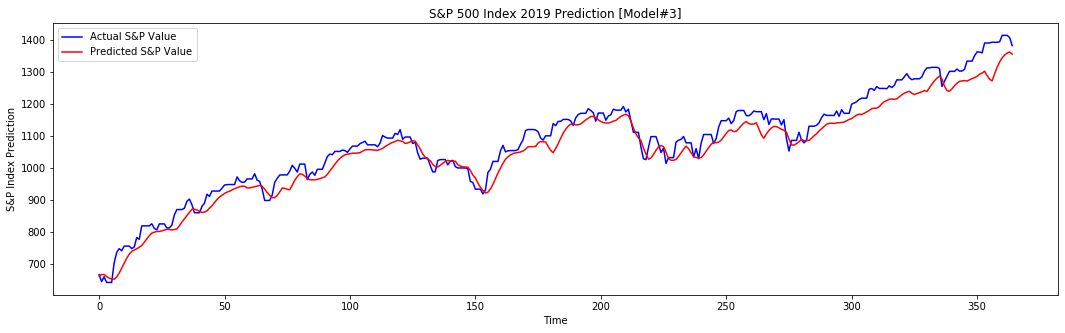

The RMSE of this Model is 38.4998567603658


In [79]:
ScaleGraphEval(y_pred3,'S&P 500 Index 2019 Prediction [Model#3]')


#### Model4

In [66]:
#This is my 4th and last model 
regressor = Sequential()
#I added a third layer to see if doing so would improve my results 
regressor.add(LSTM(units = 150, activation='relu',return_sequences = True, input_shape=(X_train.shape[1],5)))
regressor.add(Dropout(0.15))
#Here I followed the same pattern of decreasing units at ever layer
regressor.add(LSTM(units = 100, activation='relu',return_sequences = True))
regressor.add(Dropout(0.15))
#I added a dropout of .15 to each layer 
regressor.add(LSTM(units = 80, activation='relu'))
regressor.add(Dropout(0.15))

regressor.add(Dense(1))

In [67]:
#Here I see that my model is set up to my exact specifications 
regressor.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 60, 150)           93600     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 150)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 60, 100)           100400    
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 100)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 80)                57920     
_________________________________________________________________
dropout_7 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [68]:
regressor.compile(optimizer='adam', loss = 'mean_squared_error')


In [69]:
regressor.fit(X_train,y_train,epochs=180,batch_size=50)


Epoch 1/180
1033/1033 [==============================] - 3s 3ms/step - loss: 0.1029
Epoch 2/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0119
Epoch 3/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0064
Epoch 4/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 5/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0048
Epoch 6/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0045
Epoch 7/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0042
Epoch 8/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0045
Epoch 9/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0044
Epoch 10/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0037
Epoch 11/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0037
Epoch 12/180
1033/1033 [==============================] - 2s 2ms/step - lo

1033/1033 [==============================] - 2s 2ms/step - loss: 0.0016
Epoch 98/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0015
Epoch 99/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0018
Epoch 100/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0018
Epoch 101/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0016
Epoch 102/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0017
Epoch 103/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0017
Epoch 104/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0015
Epoch 105/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0017
Epoch 106/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0017
Epoch 107/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0015
Epoch 108/180
1033/1033 [==============================] - 2s 2ms/step

In [71]:
y_pred4 = regressor.predict(X_test)


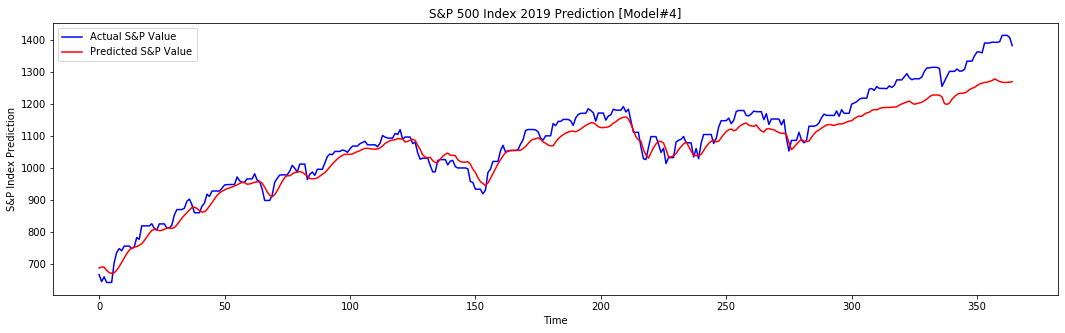

The RMSE of this Model is 45.674529738641944


In [80]:
ScaleGraphEval(y_pred4,'S&P 500 Index 2019 Prediction [Model#4]')
#This is my Final Model 